
🔹 Linear Regression Model Evaluation:
MAE: 0.12
MSE: 0.28
R² Score: 0.99

🔹 XGBoost Model Evaluation:
MAE: 0.00
MSE: 0.04
R² Score: 1.00


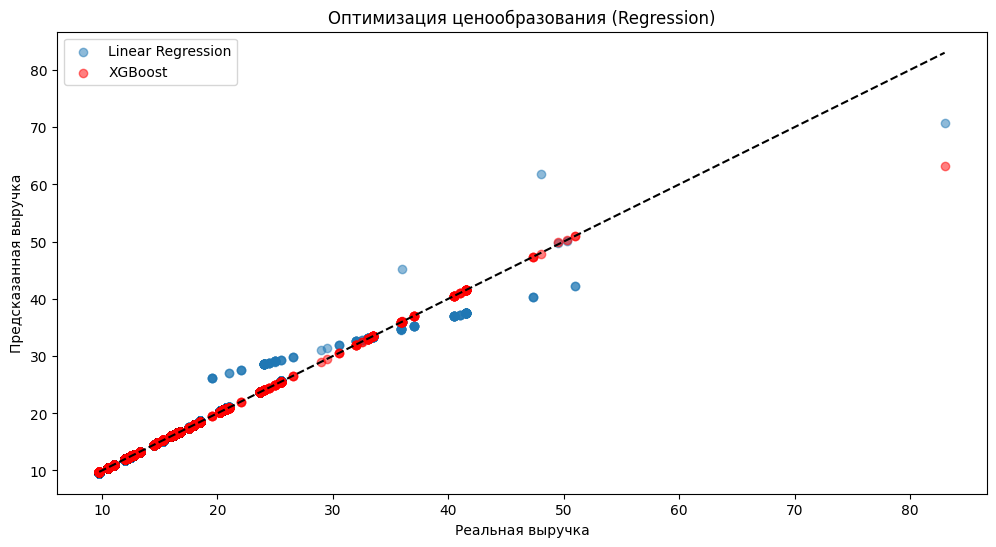

In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Подключаемся к базе
con = duckdb.connect(database=":memory:", read_only=False)

# Загружаем CSV-файлы
con.execute("CREATE TABLE orders AS SELECT * FROM read_csv_auto('Sales Data/orders.csv');")
con.execute("CREATE TABLE order_details AS SELECT * FROM read_csv_auto('Sales Data/order_details.csv');")
con.execute("CREATE TABLE pizzas AS SELECT * FROM read_csv_auto('Sales Data/pizzas.csv');")
con.execute("CREATE TABLE pizza_types AS SELECT * FROM read_csv_auto('Sales Data/pizza_types.csv');")

# Формируем нужные данные
query = """
SELECT 
    pizzas.size,
    pizza_types.category,
    orders.time,
    order_details.quantity,
    pizzas.price,
    (order_details.quantity * pizzas.price) AS revenue
FROM orders
JOIN order_details ON orders.order_id = order_details.order_id
JOIN pizzas ON order_details.pizza_id = pizzas.pizza_id
JOIN pizza_types ON pizzas.pizza_type_id = pizza_types.pizza_type_id
"""

df = con.execute(query).fetchdf()

# 🔹 Преобразуем категориальные признаки (размер пиццы и категорию) в числовые
df = pd.get_dummies(df, columns=['size', 'category'], drop_first=True)

# 🔹 Преобразуем время заказа в числовой формат (часы)
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# 🔹 Определяем признаки (X) и целевую переменную (y)
X = df.drop(columns=['revenue'])  # Все признаки, кроме выручки
y = df['revenue']  # Целевая переменная - выручка

# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Обучаем **Linear Regression**
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 🔹 Обучаем **XGBoost**
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 🔹 Оцениваем модели
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔹 {name} Model Evaluation:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.2f}")

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("XGBoost", y_test, y_pred_xgb)

# 🔹 Визуализация
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label="XGBoost", alpha=0.5, color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Линия идеального предсказания
plt.xlabel("Реальная выручка")
plt.ylabel("Предсказанная выручка")
plt.title("Оптимизация ценообразования (Regression)")
plt.legend()
plt.show()